# Text generation: auto-completion system

In [1]:
# OS
import os

# Data Handling
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
from torch import nn
import torch.nn.functional as F

%matplotlib inline

In [ ]:
print("Pytorch version: ", torch.__version__)

In [2]:
import sys
sys.path.append('..')

from utils.s3_class import S3Functions

s3_funcs = S3Functions(bucket_name='jdgallegoq-text-gen')

In [3]:
# reproduce same results
SEED = 42
# seed on torch
torch.manual_seed(SEED)

## Load data

In [4]:
# load dataset
with s3_funcs.read_object('Dailog-dataset.dialogs_dataset') as f:
    dialogs = pickle.load(f)
len(dialogs)

64776

In [5]:
# print a sample of 10
random.sample(dialogs, 10)

['how much is the pizza going to cost',
 'the Westgate one please',
 'No Juliet, the heated swimming pool is key in our dinner can we find another option around there?',
 'Great! Thank you for doing this for me',
 'I really want Mediterranean food tonight, somewhere that takes reservations',
 'I looking for a theater in Naperville IL',
 ' Thanks so much! ',
 "Alright, I'll see you soon",
 'He did not say who would leave that inheritance in his will?',
 "Awesome! You're the best"]

## Preprocess

In [6]:
# text cleaning
dialogs_clean = []

for i in dialogs:
    # remove everything except alphabets
    i = re.sub("[^a-zA-Z' ]", "", i)
    # convert text to lowercase
    i = i.lower()
    # add cleaned text to the list
    dialogs_clean.append(i)

In [7]:
# print a sample of 10
random.sample(dialogs_clean, 10)

[' i appreciate your help',
 'can you get me tickets for a movie',
 'beef and veggie',
 "it's ok for me",
 'pepperoni and onions',
 ' get me the next appointment at intelligent auto solutions',
 'hey can you find me a restaurant',
 'book an appointment with intelligent auto solutions',
 'that sounds about right',
 'hi i have just landed at slc airport']

In [8]:
# term frequency
all_words = " ".join(dialogs_clean).split()

# create dictionary
words_dict = {}
for word in all_words:
    if word in words_dict:
        # increment count by 1
        words_dict[word] = words_dict[word] + 1
    else:
        words_dict[word] = 1

In [9]:
# preprare a dataset
words_df = pd.DataFrame({
    "word": list(words_dict.keys()),
    "count": list(words_dict.values())
})
# sort
words_df = words_df.sort_values(by='count')
words_df.reset_index(inplace=True, drop=True)
words_df.head(3)

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1


In [10]:
words_df.tail(2)

,word,count
11145,the,15406
11146,i,19654


In [11]:
# vocab size
len(words_df)

11147

In [12]:
# find and replace rare tokens
# replace with UNKNOW TOKEN
# define rarity threshold
rare_thres = 4

# get percentage of rare tokens
rare_words_count = len(words_df[words_df['count']<rare_thres]['word'])
total_word = len(words_df)
rare_dist = rare_words_count / total_word

rare_cover = words_df[words_df['count'] < rare_thres]['count'].sum()/words_df['count'].sum()

print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [13]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thres]['word'].tolist()

In [14]:
# create a pattern with regex
pattern = ""
for i in rare_words:
    pattern += " {} |".format(i)

# remove the last '|' from the pattern
pattern = pattern[:-1]

# empty list for clean text
dialogs_clean_no_rare_words = []
for d in tqdm(dialogs_clean):
    text = re.sub(pattern, " <unk> ", d)
    dialogs_clean_no_rare_words.append(text)

100%|██████████| 64776/64776 [00:10<00:00, 6324.90it/s]


In [15]:
dialogs_clean_no_rare_words[520:530]

['does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> parkconv <unk> convention center drive <unk> park il',
 'bowling alley <unk> highway <unk> park il',
 'what types of cars does uber have',
 "what's the price difference",
 'ok get me the cheapest please',
 'ok then get me the next level']

In [16]:
# preprare sequences
# 1. define sequence lenght based on distribution of sentence lenghts
def create_seq(text, seq_lenght=5):
    sequence = []
    if len(text.split())>seq_lenght:
        for i in range(seq_lenght, len(text.split())):
            seq = text.split()[i-seq_lenght: i+1]
            sequence.append(" ".join(seq))

        return sequence

    else:
        return [text]

In [17]:
seqs = [create_seq(i) for i in dialogs_clean_no_rare_words]

In [18]:
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [19]:
# merge to a single list
seqs = sum(seqs, [])
seqs[:15]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the",
 'want to sit at the bar',
 'to sit at the bar but',
 'sit at the bar but anywhere',
 'at the bar but anywhere else',
 'the bar but anywhere else is']

In [20]:
# count sequences
len(seqs)

205346

In [21]:
# create input and target sequences (x and y)
x = []
y = []
for s in seqs:
    x.append(" ".join(s.split()[:-1]))
    y.append(" ".join(s.split()[1:]))

x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [22]:
# create token-integer mappings
# text-gen works like generation integers
# that need to be converted into tokens by mapping
# the vocabulary

int2token = {}
count = 1

for w in set(" ".join(dialogs_clean_no_rare_words).split()):
    int2token[count] = w
    count += 1

# token to integer mapping (inverse of above)
token2int = {v: k for k, v in int2token.items()}

token2int['can'], int2token[1127]

(500, 'bald')

## Split data

In [23]:
split_thres = 150000

x_train = x[:split_thres]
x_val = x[split_thres:]
y_train = y[:split_thres]
y_val = y[split_thres:]

## Pad sequences
Explore sequence lenghts to get the optimal padding lenght

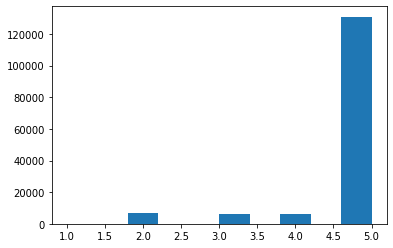

In [24]:
plt.hist([len(i.split()) for i in x_train])
plt.show()

In [25]:
# max lenght should be 5
max_text_len = 5

def pad_sequences(seq, n):
    # get tokens from seq
    seq = seq.split()
    # check if seq len < n
    if len(seq)<n:
        for i in range(n-len(seq)):
            seq.append("<pad>")
    return " ".join(seq)

In [26]:
# pad sequences
x_train_pad = [pad_sequences(s, max_text_len) for s in x_train]
y_train_pad = [pad_sequences(s, max_text_len) for s in y_train]

x_val_pad = [pad_sequences(s, max_text_len) for s in x_val]
y_val_pad = [pad_sequences(s, max_text_len) for s in y_val]

In [27]:
x_train_pad[:20]

["hi i'm looking to book",
 "i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 "we don't want to sit",
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'what times are <pad> <pad>',
 "yikes we can't do those",
 'let me <pad> <pad> <pad>',
 "great let's book <pad> <pad>"]

In [28]:
y_train_pad[:20]

["i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'a table for korean fod',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'nyc maybe the east village',
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'but anywhere else is fine',
 'times are available <pad> <pad>',
 "we can't do those times",
 'me check <pad> <pad> <pad>',
 "let's book that <pad> <pad>"]

In [29]:
# update vocab
int2token[0] = "<pad>"
token2int["<pad>"] = 0
# get vocab size
vocab_size = len(int2token)

In [30]:
# convert padded sequences to integers
def get_integer_seq(seq):
    return [token2int[w] for w in seq.split()]

In [31]:
# apply above function to x and y
x_train_int = [get_integer_seq(s) for s in x_train_pad]
y_train_int = [get_integer_seq(s) for s in y_train_pad]
x_val_int = [get_integer_seq(s) for s in x_val_pad]
y_val_int = [get_integer_seq(s) for s in y_val_pad]

In [32]:
x_train_int[:10]

[[5901, 2632, 2554, 2894, 5781],
 [2632, 2554, 2894, 5781, 1031],
 [2554, 2894, 5781, 1031, 549],
 [2894, 5781, 1031, 549, 5428],
 [5781, 1031, 549, 5428, 775],
 [2715, 1324, 2515, 4228, 5350],
 [1324, 2515, 4228, 5350, 3656],
 [2515, 4228, 5350, 3656, 815],
 [5435, 1239, 5790, 2894, 87],
 [1239, 5790, 2894, 87, 3969]]

In [33]:
y_train_int[:10]

[[2632, 2554, 2894, 5781, 1031],
 [2554, 2894, 5781, 1031, 549],
 [2894, 5781, 1031, 549, 5428],
 [5781, 1031, 549, 5428, 775],
 [1031, 549, 5428, 775, 4040],
 [1324, 2515, 4228, 5350, 3656],
 [2515, 4228, 5350, 3656, 815],
 [4228, 5350, 3656, 815, 1525],
 [1239, 5790, 2894, 87, 3969],
 [5790, 2894, 87, 3969, 3656]]

In [34]:
# convert lists into arrays
x_train_int = np.array(x_train_int)
y_train_int = np.array(y_train_int)
x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_train_int.shape, y_train_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

## Model Building
-> embedding layer:</br>
    - input dim: vocab size</br>
    - output dim: 200 (hyperparameter)

In [35]:
class WordLSTM(nn.Module):
    def __init__(
            self,
            n_hidden=256,
            n_layers=2,
            drop_prob=0.3,
            lr=1e-3
        ):

        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr

        self.emb_layer = nn.Embedding(vocab_size, 200)

        # define LSTM
        # as input shape is (batch size, seq len, num features)
        # set batch_first=True
        self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)

        # Droput layer
        self.droput = nn.Dropout(drop_prob)

        # Dense layer
        self.fc = nn.Linear(n_hidden, vocab_size)
    
    def forward(self, x, hidden):
        # get embed layer
        embedded = self.emb_layer(x)
        # pass it to LSTM
        lstm_out, hidden = self.lstm(embedded, hidden)
        # pass lstm_out to dropout
        out = self.droput(lstm_out)
        # reshape (batch size*seq_len, hidden_units)
        out = out.reshape(-1, self.n_hidden)
        # pass out to dense
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """
            initialize first hidden and cell state for LSTM
        """
        weight = next(self.parameters()).data

        if (torch.cuda.is_available()):
            hidden = (
                # this first one for the hidden state
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                # this second one for the cell state
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda()
            )
        else:
            hidden = (
                # this first one for the hidden state
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                # this second one for the cell state
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_()
            )
        
        return hidden

In [36]:
# summary
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6502, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (droput): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6502, bias=True)
)


In [37]:
# define function to pass batches
def get_batches(x_array, y_array, batch_size):
    prv = 0
    for n in range(batch_size, x_array.shape[0], batch_size):
        # batch for input
        x = x_array[prv:n, :]
        # batch for target
        y = y_array[prv:n, :]
        prv = n

        yield x, y

## Train

In [38]:
def train(
    net,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    print_every=32,
    save_path='../module/models'
):
    # set initial loss to infinite
    best_valid_loss = float('inf')
    # optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    # loss funtion
    criterion = nn.CrossEntropyLoss()
    # if GPU available push model to GPU
    if (torch.cuda.is_available()):
        net.cuda()
    
    counter = 0
    net.train()
    for e in range(epochs):
        # iterate over batches
        for x, y in get_batches(x_train_int, y_train_int, batch_size):
            counter += 1
            # convert arrays to tensors
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            # if GPU available then push tensors to GPU
            if (torch.cuda.is_available()):
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # initialize hidden state
            # this prevents to carry on information from
            # previous batches
            h = net.init_hidden(batch_size)
            # set accumulated gradients to zero
            net.zero_grad()
            # get output from the model
            output, h = net(inputs, h)
            # calculate loss and do backward
            loss = criterion(output, targets.view(-1))
            loss.backward()
            # optimier step
            opt.step()

            if counter % print_every == 0:
                # get val loss
                val_losses = []
                net.eval()

                for x, y in get_batches(x_val_int, y_val_int, batch_size):
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    val_h = net.init_hidden(batch_size)

                    inputs, targets = x, y
                    if (torch.cuda.is_available()):
                        inputs, targets = inputs.cuda(), targets.cuda()
                    
                    output, val_h = net(inputs, val_h)

                    val_loss = criterion(output, targets.view(-1))
                    val_losses.append(val_loss.item())
                
                # save best model
                if np.mean(val_losses) < best_valid_loss:
                    best_valid_loss = np.mean(val_losses)
                    torch.save(net.state_dict(), f'{save_path}/saved_weights.pt')
                
                net.train()

                print(
                    "Epoch: {}/{}".format(e+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.4f}...".format(loss.item()),
                    "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
                    "Val Loss: {:.4f}".format(np.mean(val_losses))
                )

In [39]:
# define batch size
batch_size = 64
epochs = 10
# train model
train(net, batch_size=batch_size, epochs=epochs)

Epoch: 1/10 Step: 32... Loss: 6.4171... ppl: 686.5443  Val Loss: 6.5317
Epoch: 1/10 Step: 64... Loss: 5.6239... ppl: 342.2799  Val Loss: 5.8356
Epoch: 1/10 Step: 96... Loss: 6.0970... ppl: 273.6285  Val Loss: 5.6118
Epoch: 1/10 Step: 128... Loss: 5.2977... ppl: 238.7068  Val Loss: 5.4752
Epoch: 1/10 Step: 160... Loss: 6.1782... ppl: 210.6979  Val Loss: 5.3504
Epoch: 1/10 Step: 192... Loss: 5.7520... ppl: 186.9139  Val Loss: 5.2306
Epoch: 1/10 Step: 224... Loss: 5.1411... ppl: 167.1139  Val Loss: 5.1187
Epoch: 1/10 Step: 256... Loss: 4.2456... ppl: 151.4281  Val Loss: 5.0201
Epoch: 1/10 Step: 288... Loss: 4.9037... ppl: 138.7299  Val Loss: 4.9325
Epoch: 1/10 Step: 320... Loss: 4.9328... ppl: 128.7778  Val Loss: 4.8581
Epoch: 1/10 Step: 352... Loss: 4.3324... ppl: 119.6864  Val Loss: 4.7849
Epoch: 1/10 Step: 384... Loss: 4.9985... ppl: 112.2930  Val Loss: 4.7211
Epoch: 1/10 Step: 416... Loss: 4.9008... ppl: 107.2934  Val Loss: 4.6756
Epoch: 1/10 Step: 448... Loss: 4.5394... ppl: 102.8382

KeyboardInterrupt: 